# PanSTARRS - WISE crossmatch: Pre-configure the ML parameters

In this step we will prepare the auxiliary variables used for the ML

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
import pickle

In [2]:
from mltier1 import get_center, get_n_m, estimate_q_m, Field

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
field = Field(170.0, 190.0, 45.5, 56.5)

## Load the data

### Load the catalogues

In [5]:
panstarrs_full = Table.read("panstarrs_u2.fits")

In [6]:
wise_full = Table.read("wise_u2.fits")

In [7]:
panstarrs = field.filter_catalogue(
    panstarrs_full, 
    colnames=("raMean", "decMean"))

In [8]:
# Free memory
del panstarrs_full

In [9]:
wise = field.filter_catalogue(
    wise_full, 
    colnames=("raWise", "decWise"))

In [10]:
# Free memory
del wise_full

### Coordinates

As we will use the coordinates to make a cross-match we to load them

In [11]:
coords_panstarrs = SkyCoord(panstarrs['raMean'], panstarrs['decMean'], unit=(u.deg, u.deg), frame='icrs')

In [12]:
coords_wise = SkyCoord(wise['raWise'], wise['decWise'], unit=(u.deg, u.deg), frame='icrs')

## Compute the ML parameters

### Number of sources per magnitude in i-band

In [13]:
bin_list = np.linspace(12., 30., 1801)

In [14]:
center = get_center(bin_list)

In [15]:
n_m = get_n_m(panstarrs["i"], bin_list, field.area)

Number of sources per magnitude per unit area in the selected region (cumulative distribution). This sets the number of background sources. The units of this are N/(square arcsec) per magnitude.

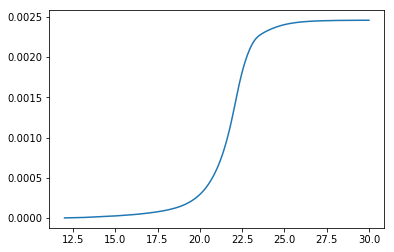

In [16]:
plot(center, n_m);

### Compute real(m) and q(m)

The first step is to crossmatch the catalogues to make an estimation

In [17]:
radius = 5 # arcseconds

In [18]:
q_m = estimate_q_m(panstarrs["i"], bin_list, n_m, coords_wise, coords_panstarrs, radius=5)

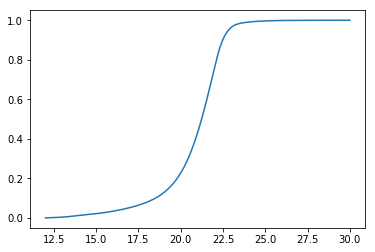

In [19]:
plot(center, q_m);

### Estimated $Q_0$

In [20]:
q0 = 0.62

## Save the parameters

In [21]:
pickle.dump([bin_list, center, q0, n_m, q_m], open("pw_params.pckl", 'wb'))